# Trie Time

Python's `defaultdict`, Efficient Membership Tests, and Grouping Words By Prefix

## Dictionaries All the Way Down

![Don't Get Munsoned](resources/dictionary_salesman.jpg)

## `KeyError`s are Annoying

In [3]:
d = {}
d['flan'] = {}
try:
   d['bender']
except KeyError:
    print ":sadpanda:", d

:sadpanda: {'flan': {}}


# `setdefault` and `defaultdict`

In [4]:
sd = {}
a = sd.setdefault('bender', [])
sd.setdefault('nibbler', {})['leela'] = 'why not zoidberg'
print a, sd

[] {'nibbler': {'leela': 'why not zoidberg'}, 'bender': []}


In [5]:
from collections import defaultdict
dd = defaultdict(dict)
dd[1][2] = 3
try:
    dd[4][5]
except KeyError:
    print ":sadpanda:", dd

:sadpanda: defaultdict(<type 'dict'>, {1: {2: 3}, 4: {}})


In [6]:
dd_callable = defaultdict(lambda: defaultdict(dict))
try:
    dd_callable[3][4][5]
except KeyError:
    print ":sadpanda:", dd_callable

:sadpanda: defaultdict(<function <lambda> at 0x10ab87410>, {3: defaultdict(<type 'dict'>, {4: {}})})


# Yo Dawg
![xzibit](resources/yo_dawg.jpg)

In [7]:
def infinite_defaultdict():
    return defaultdict(infinite_defaultdict)
idd = infinite_defaultdict()
idd['x']['y']['z']['a']['b']['c']
print dict(idd)

{'x': defaultdict(<function infinite_defaultdict at 0x10ab87320>, {'y': defaultdict(<function infinite_defaultdict at 0x10ab87320>, {'z': defaultdict(<function infinite_defaultdict at 0x10ab87320>, {'a': defaultdict(<function infinite_defaultdict at 0x10ab87320>, {'b': defaultdict(<function infinite_defaultdict at 0x10ab87320>, {'c': defaultdict(<function infinite_defaultdict at 0x10ab87320>, {})})})})})})}


# Re'trie'val

- a trie is a tree that stores items with a common prefix on the same branch
- Fast lookups with recursion
  - Max width (number of possible letters + 1)
  - Max height (longest word + 1)
- Answers some 'hard' questions really easily (autocomplete)
![trie](resources/trie.png)

# Portmanteaus are cool

- `defaultdictrie`

In [8]:
import io
import sys

def TrieNode():
    return defaultdict(TrieNode)

def add_word(word, node):
    if not word:
        node[None] = None
        return
    add_word(word[1:], node[word[0]])
    
def exists(word, node):
    if not word:
        return None in node
    return exists(word[1:], node[word[0]])

In [9]:
root = TrieNode()
wordfile = 'wordlist.txt' # http://codekata.com/kata/kata06-anagrams/
word_list = []

with io.open(wordfile, encoding='latin-1') as wf:
    for line in wf:
        word = line.strip()
        word_list.append(word)
        add_word(word, root)
word_set = set(word_list)

In [10]:
def _path(node, path=''):
    # DFS, basically
    for k, v in node.iteritems():
        if k is None:
            yield path
            continue
        new_path = ''.join((path, k))
        for p in _path(v, new_path):
            yield p

def find_words_with_prefix(prefix, node):
    
    original = prefix
    # find the start node
    while prefix:
        node = node[prefix[0]]
        prefix = prefix[1:]
        
    for path in _path(node, original):
        yield path
            
PREFIX_TO_FIND = 'casti'        
sorted(find_words_with_prefix(PREFIX_TO_FIND, root), key=len)

[u'casting',
 u'castings',
 u'castigate',
 u"casting's",
 u'castigates',
 u'castigated',
 u'castigator',
 u'castigation',
 u'castigating',
 u'castigatory',
 u'castigators',
 u'castigations',
 u"castigator's",
 u"castigation's"]

## Are we sure it's correct?

In [11]:
def find_words_in_container_with_prefix(prefix, container):
    for word in container:
        if word.startswith(prefix):
            yield word

In [12]:
list_from_a = sorted(find_words_in_container_with_prefix(PREFIX_TO_FIND, word_list))
list_from_b = sorted(find_words_with_prefix(PREFIX_TO_FIND, root))
assert list_from_a == list_from_b

# Why use this?

![but why](resources/but_why.gif)

- membership tests are much faster than list, slightly slower than set
  - lookups are `O(m)`, where `m` is the number of letters in the word
- find all words that start with 'cat'
  - much faster than naive solutions, though there is a memory cost

### Membership Test Performance

In [13]:
s = 'castigate'
assert exists(s, root) and s in word_list and s in word_set

In [14]:
%timeit s in word_list

100 loops, best of 3: 7.43 ms per loop


In [15]:
%timeit s in word_set

The slowest run took 25.34 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 160 ns per loop


In [16]:
%timeit exists(s, root)

100000 loops, best of 3: 2.66 µs per loop


In [17]:
%timeit exists('cat', root)

The slowest run took 4.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 941 ns per loop


In [18]:
%timeit exists('flargle', root)

The slowest run took 5.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.89 µs per loop


In [19]:
%timeit 'flargle' in word_set

The slowest run took 42.89 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 44.5 ns per loop


In [20]:
%pylab inline
import bisect

funcs = dict(List=lambda x: x in word_list, 
             Set=lambda x: x in word_set,
             Trie=lambda x: exists(x, root), ListBinSearch=lambda x: bisect.bisect(word_list, x))
values = sorted([w for w in find_words_with_prefix('cast', root) if "'" not in w], key=len)

data = defaultdict(lambda : defaultdict(list))
for name, func in funcs.iteritems():
    seen = set()
    for v in values:
        x = len(v)
        if x in seen:
            continue
        seen.add(x)
        y = %timeit -n1000 -q -o func(v)
        data[name]['x'].append(x)
        data[name]['y'].append(y.best)

Populating the interactive namespace from numpy and matplotlib


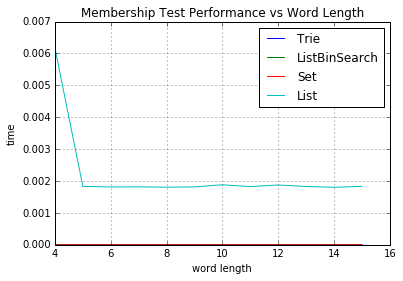

In [21]:
fig, ax = subplots()
for i, (k, v) in enumerate(data.iteritems()):
    plot(v['x'], v['y'], label=k)   
ax.legend()
ax.set_xlabel("word length")
ax.set_ylabel("time")
ax.set_title("Membership Test Performance vs Word Length")
ax.grid(True)

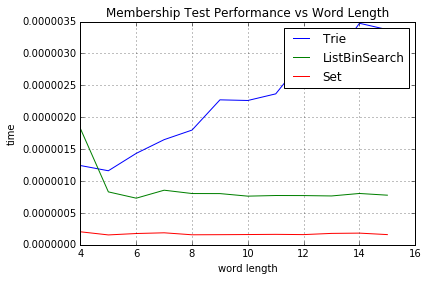

In [22]:
fig, ax = subplots()
for i, (k, v) in enumerate(data.iteritems()):
    if k == 'List':
        continue
    plot(v['x'], v['y'], label=k)    
ax.legend()
ax.set_xlabel("word length")
ax.set_ylabel("time")
ax.set_title("Membership Test Performance vs Word Length")
ax.grid(True)

### Find Word with Prefix Performance

In [23]:
%timeit list(find_words_in_container_with_prefix(PREFIX_TO_FIND, word_list))

10 loops, best of 3: 81.7 ms per loop


In [24]:
%timeit list(find_words_in_container_with_prefix(PREFIX_TO_FIND, word_set))

10 loops, best of 3: 152 ms per loop


In [25]:
%timeit list(find_words_with_prefix(PREFIX_TO_FIND, root))

10000 loops, best of 3: 23.4 µs per loop


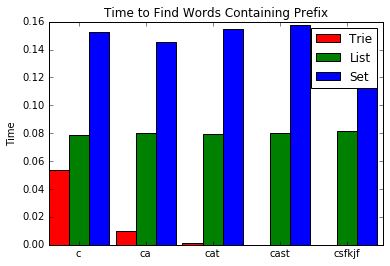

In [26]:
funcs = dict(List=lambda x:list(find_words_in_container_with_prefix(x, word_list)),
             Set=lambda x: list(find_words_in_container_with_prefix(x, word_set)),
             Trie=lambda x: list(find_words_with_prefix(x, root)))
values = ['c', 'ca', 'cat', 'cast', 'csfkjf']
ind = np.arange(len(values))
width = 0.30
fig, ax = subplots()
for i, name in enumerate(['Trie', 'List', 'Set']):
    y = []
    for v in values:
        t = %timeit -n10 -q -o funcs[name](v)
        y.append(t.best)
    bar(ind + (i*width), y, width, color='rgb'[i], label=name)
ax.legend()
ax.set_ylabel('Time')
ax.set_title('Time to Find Words Containing Prefix')
ticks = ax.set_xticks(ind + (width * len(funcs) / 2.0))
labels = ax.set_xticklabels(values)

## Measuring Memory

- NOT space efficient
- somewhat misleading
- harder to measure

In [27]:
len(root), len(word_list), len(word_set)

(57, 338882, 338882)

In [28]:
sys.getsizeof(root), sys.getsizeof(word_list), sys.getsizeof(word_set)

(3352, 3012912, 8388840)

In [29]:
AVERAGE_WORD_LENGTH = sum(len(w) for w in word_list) * 1.0 / len(word_list)
LONGEST_WORD = max(len(w) for w in word_list)
print AVERAGE_WORD_LENGTH, LONGEST_WORD
sys.getsizeof(root) * len(root) * LONGEST_WORD

9.20367266482 60


11463840

In [31]:
max_depth = 0
max_width = 0
def rec_size_of(d, depth=0, width=0):
    global max_depth, max_width
    max_depth = max(depth, max_depth)
    max_width = max(width, max_width)
    if d is None:
        return sys.getsizeof(d)
    return sys.getsizeof(d) + sum(rec_size_of(v, depth + 1, width+1)
                                  for v in d.itervalues())

print rec_size_of(root), max_depth, max_width

233391968 61 61


In [32]:
import cPickle as pickle
set_string = pickle.dumps(word_set)
trie_string = pickle.dumps(root)
a, b = sys.getsizeof(set_string), sys.getsizeof(trie_string)
print a, b, a - b

6735224 17431299 -10696075
